In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline

### Excercise 1. Implement AdaBoost

In [2]:
def load_data(file_name):
    data = np.array(pd.read_csv(file_name, sep=',', header=None))
    np.random.shuffle(data)
    split_index = int(len(data)*0.8)
    X_train, y_train = data[0:split_index,0:-1], data[0:split_index,-1]
    X_test, y_test = data[split_index:,0:-1], data[split_index:,-1]
    y_train = np.where(y_train == 0, -1, y_train)
    y_test = np.where(y_test == 0, -1, y_test)
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_data(file_name='spambase/spambase.data')

In [4]:
def binarize_features(data):
    binary = []
    for feature in data.T:
        binary.append([1 if x >= np.mean(feature) else 0 for x in feature])
    return np.array(binary).T

In [5]:
X_train = binarize_features(X_train)
X_test = binarize_features(X_test)

In [6]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
predictions = np.mean(cross_val_score(tree, X_train, y_train,cv=10))
print('accuracy:',predictions*100,'%')

accuracy: 78.77781762875678 %


In [7]:
class AdaBoost:
    def __init__(self, T):
        self.T = T
        self.models = []
        self.alphas = []
        self.predictions = []
        self.errors = []
    
    def fit(self, X, y):
        weights = [1/i for i in range(1, len(X)+1)]
        
        for t in range(self.T):
            classifier = DecisionTreeClassifier(criterion='entropy', max_depth=1)
            model = classifier.fit(X, y, sample_weight=weights)
            prediction = model.predict(X)
            wrong = np.where(prediction != y, 1, 0)
            error = np.sum(weights * wrong) / np.sum(weights)
            alpha = np.log((1 - error) / error)
            weights = weights * np.exp(alpha * wrong)
            
            self.models.append(model)
            self.alphas.append(alpha)
            self.errors.append(len([np.where(prediction != y)][0][0])/len(y))
        return self
    
    def predict(self, X_test):
        for alpha,model in zip(self.alphas,self.models):
            self.predictions.append(alpha * model.predict(X_test))
        
        return np.sign(np.sum(self.predictions, axis=0))

    def plot(self):
        plt.plot(self.errors)

In [8]:
ada = AdaBoost(100)

In [9]:
ada.fit(X_train, y_train)
prediction = ada.predict(X_test)

In [10]:
def confusion_matrix(labels, predictions):
    size = len(set(labels))
    matrix = np.zeros((size, size))
    for correct, predicted in zip(labels.astype(int), predictions.astype(int)):
        matrix[correct][predicted] += 1
    return matrix

In [11]:
wrong = np.where(prediction != y_test)

In [12]:
accuracy = 1-len(wrong)/len(y_test)
print('accuracy:', accuracy*100)
print(confusion_matrix(y_test, prediction))

accuracy: 99.8914223669924
[[  0.   0.]
 [  0. 921.]]


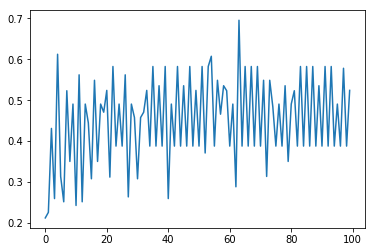

In [13]:
ada.plot()